# **EVALUATING STORM'S PERFORMANCE** #

#### Objectives: ####
+ Evaluate the performance of STORM rainfall fields
+ More recipes for awesome spatial plotting via [Xarray](https://docs.xarray.dev/en/stable/)

---

Let's see how well/bad STORM captures/simulates seasonal rainfall; and how far off the current parameterization is.

---

## <u>ONE SIMULATED-SEASON</u>  $\to$  CLUSTERS $\equiv$ 1 ##

In [3]:
# loading libraries
import cmaps  # -> nice color-palettes
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rio
import xarray as xr
from cmcrameri import cm as cmc
from rasterio.enums import Resampling

Start by reading the output produced by STORM.

<span style="color:RoyalBlue">STORM exports its outputs to the folder [**model_output**](../model_output).</span>

<span style="color:HotPink">*Note: The exercise carried out here is for a (simulated) MAM season.*</span>

In [5]:
# where STORM's output is located
sfile = "../model_output/RUN_230830T1526_S1_ptotC_stormsC.nc"  # -> 1 CLUSTER

# read the NetCDF file via Xarray
ds = xr.open_mfdataset(
    sfile,
    group="run_01",
    # concat_dim='time',
    combine="nested",
    decode_times=True,
    use_cftime=True,
    decode_cf=True,
    mask_and_scale=True,
    # data_vars=['rain'],
)
ds = ds.assign_coords(
    {"y": ds.projection_y_coordinate.load(), "x": ds.projection_x_coordinate.load()}
)

# load the simulated year to work with
storm = ds["year_2023"].load()
# load also the k-means (for comparison purposes)
skams = ds["k_means"].load()
ds.close()

# how does rainfall look like?
storm

<xarray.DataArray 'year_2023' (time_001: 3515, y: 470, x: 408)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
    projection_y_coordinate  (y) int32 1167500 1162500 ... -1172500 -1177500
    projection_x_coordinate  (x) int32 1342500 1347500 ... 3372500 3377500
  * time_001                 (time_001) object 2023-03-01 02:30:00 ... 10136-...
  * y                        (y) int32 1167500 1162500 ... -1172500 -1177500
  * x                        (x) int32 1342500 1347500 ... 3372500 3377500
Attributes:
    precision:     0.002
    units:         mm
    long_name:     rainfall
    grid_mapping:  spatial_ref

Note that we have a Xarray with $\sim3500$ half-hours (in the time dimension).
That's pretty much equivalent to having $48 \times 30 \times 3 \approx 4300$ storms.
Which can be seen as having at least one storm every half hour somewhere in the HAD.

In [6]:
# how does k-means look like?
skams

<xarray.DataArray 'k_means' (y: 470, x: 408)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    projection_y_coordinate  (y) int32 1167500 1162500 ... -1172500 -1177500
    projection_x_coordinate  (x) int32 1342500 1347500 ... 3372500 3377500
  * y                        (y) int32 1167500 1162500 ... -1172500 -1177500
  * x                        (x) int32 1342500 1347500 ... 3372500 3377500
Attributes:
    grid_mapping:  spatial_ref
    long_name:     k-means clusters
    description:   -1 indicates region out of any cluster

We're not interested here in checking individual storms... <span style="color:RoyalBlue">that's what notebook [**for_**](../for_.ipynb) is for</span> <span style="color:MediumSeaGreen">*(pun! --lol--).*</span>\
Thus, we aggregate all rainfall across the time-axis to obtain total seasonal rainfall (across the HAD).\
<span style="color:HotPink">*(Computation of the following block is somewhat "time-consuming")*</span>

In [7]:
# first we do some rounding
tormen = storm.astype("f8").round(3)
# ...and then the aggregation over time
season = tormen.sum(axis=0)

# how does...
season

<xarray.DataArray 'year_2023' (y: 470, x: 408)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    projection_y_coordinate  (y) int32 1167500 1162500 ... -1172500 -1177500
    projection_x_coordinate  (x) int32 1342500 1347500 ... 3372500 3377500
  * y                        (y) int32 1167500 1162500 ... -1172500 -1177500
  * x                        (x) int32 1342500 1347500 ... 3372500 3377500

Can we see some numbers somewhere?

In [8]:
# a spatial chunk of the season
season[2:7, 160:165]

<xarray.DataArray 'year_2023' (y: 5, x: 5)>
array([[  0.   ,   0.   ,   0.   ,  82.888,  54.052],
       [ 77.368,  70.174,  72.594,  69.088,  85.746],
       [106.796,  86.17 ,  95.222,  91.568,  89.474],
       [ 99.708, 111.044, 153.232, 109.89 , 106.454],
       [120.286, 131.718, 125.342, 121.31 , 110.068]])
Coordinates:
    projection_y_coordinate  (y) int32 1157500 1152500 1147500 1142500 1137500
    projection_x_coordinate  (x) int32 2142500 2147500 2152500 2157500 2162500
  * y                        (y) int32 1157500 1152500 1147500 1142500 1137500
  * x                        (x) int32 2142500 2147500 2152500 2157500 2162500

Let's upload the same cool color palettes (by now already familiar) from the [cmaps](https://github.com/hhuangwx/cmaps) library.

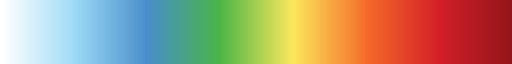

In [9]:
# https://raw.githubusercontent.com/hhuangwx/cmaps/master/examples/colormaps.png
cmaps.precip2_17lev
cmaps.wh_bl_gr_ye_re
cmaps.WhiteBlueGreenYellowRed

#### MAM SEASON (FOR 1 CLUSTER) ####

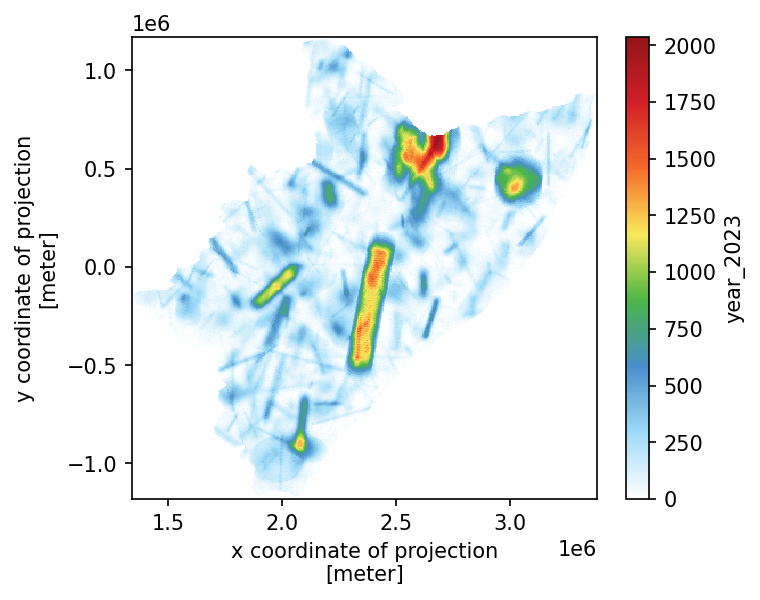

In [10]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
# ax.set_aspect("equal")
# season.plot(cmap="precip2_17lev", ax=ax)
season.plot(cmap="WhiteBlueGreenYellowRed", ax=ax)
plt.show()

So far we haven't used the [Crameri](https://www.fabiocrameri.ch/colourmaps/) library (despite we keep uploading it every time).
It is designed to be color-blind safe.
Let's have a look at it... throughout some not-that-fancy Numpy-plot.

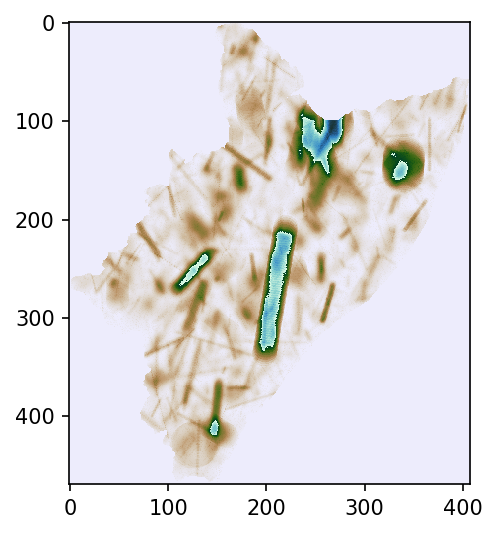

In [11]:
# not-fancy plot
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
plt.imshow(season.data, origin="upper", cmap=cmc.bukavu_r, interpolation="none")

Check out the cluster-mask stored in the output.

In [12]:
# masks
kmeans = xr.where(skams != -1, skams, np.nan)
# kmeans = skams.where(-1, np.nan)
kmeans = np.unique(kmeans.data)
kmeans = kmeans[~np.isnan(kmeans)].astype("i1")

# counting cluster-pixels
print([xr.where(skams == x, skams, np.nan).count().data for x in kmeans])

[array(86293)]


For now, STORM outputs the total seasonal rainfall achieved by the simulation <span style="color:RoyalBlue">(stored in the corresponding CSV files)</span>.\
Let's see how far off (from the mean --for the overall HAD--) the simulated seasonal field is.

In [14]:
# construct a Pandas dataframe
ks = list(map(lambda x: xr.where(skams == x, season, np.nan).mean().data, kmeans))
out_ks = pd.DataFrame({"k": kmeans, "mean_nc4": ks}, dtype="object")

# input kmeans
in_ks = pd.read_csv(sfile.replace(".nc", "_kmeans.csv"))

# KMEANS from IN/OUT
kkmm = pd.merge(in_ks, out_ks, how="left", on="k")

# how does that look like?
kkmm

,k,mean_in,mean_out,mean_xtra,mean_nc4
0,0,237.76195,237.806487,237.804079,237.8040790794155


Not bad at all, right?.
This shouldn't be that surprising.
STORM is precisely designed to stop when the seasonal average (over the catchment/region is reached).\
<span style="color:MediumSeaGreen">(do not mind the "mean_xtra" column)</span>

Let's plot now the regions/clusters.

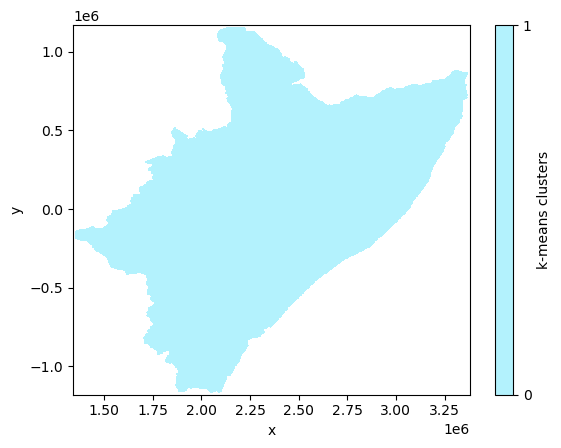

In [15]:
# skams.plot(cmap=cmc.bukavu, levels=len(kmeans)+1, vmin=0, vmax=len(kmeans))
skams.plot(cmap=cmc.hawaii_r, levels=len(kmeans) + 1, vmin=0, vmax=len(kmeans))

## <u>ONE SIMULATED-SEASON</u>  $\to$  CLUSTERS $\equiv$ 4 ##

<span style="color:HotPink">*Bear in mind that computation of the following block is somewhat "time-consuming"*</span>

In [16]:
# couple of realizations for 4 clusters
sfile = "../model_output/RUN_230901T1010_S1_nada_zero.nc"  # -> 1 CLUSTERS

# read the NetCDF file via Xarray
ds = xr.open_mfdataset(
    sfile,
    group="run_02",
    combine="nested",
    # concat_dim='time',
    decode_times=True,
    use_cftime=True,
    decode_cf=True,
    mask_and_scale=True,
    # data_vars=['rain'],
)
ds = ds.assign_coords(
    {"y": ds.projection_y_coordinate.load(), "x": ds.projection_x_coordinate.load()}
)

# load the simulated year to work with
storm_x = ds["year_2023"].load()
skams_x = ds["k_means"].load()
ds.close()

# seasonal rain
season_x = (storm_x.astype("f8").round(3)).sum(axis=0)

Straight to plotting (no need for intermediate Xarray-displaying).

#### MAM SEASON (FOR 4 CLUSTERS) ####

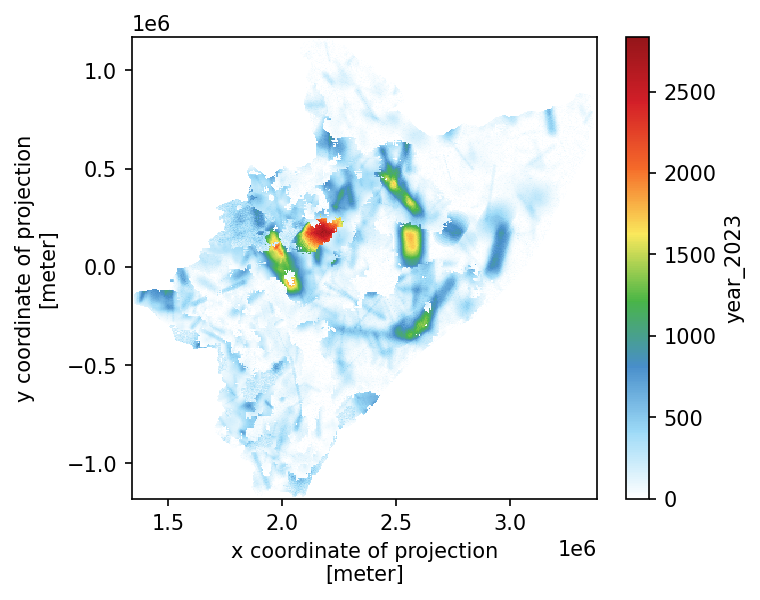

In [18]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
# ax.set_aspect("equal")
# season_x.plot(cmap="precip2_17lev", ax=ax)
season_x.plot(cmap="WhiteBlueGreenYellowRed", ax=ax)
plt.show()

Check out the cluster-mask stored in the output.

In [19]:
# masks
kmeans = xr.where(skams_x != -1, skams_x, np.nan)
# kmeans = skams_x.where(-1, np.nan)
kmeans = np.unique(kmeans.data)
kmeans = kmeans[~np.isnan(kmeans)].astype("i1")

# counting cluster-pixels
print([xr.where(skams_x == x, skams_x, np.nan).count().data for x in kmeans])

[array(5418), array(32407), array(33251), array(15217)]


In [20]:
# construct a Pandas dataframe
ks_x = list(map(lambda x: xr.where(skams_x == x, season_x, np.nan).mean().data, kmeans))
out_ks = pd.DataFrame({"k": kmeans, "mean_nc4": ks_x}, dtype="object")

# output kmeans
out_ks

,k,mean_nc4
0,0,585.1801125876708
1,1,234.3012125775295
2,2,123.34646416649124
3,3,375.2105049615562


In [21]:
# input kmeans
in_ks = pd.read_csv(sfile.replace(".nc", "_kmeans.csv"))
in_ks

,k,mean_in,mean_out,mean_xtra
0,0,122.20316,123.01343482432205,122.84915667218301
1,1,374.7068,374.86894913237956,374.7010015098805
2,2,582.65515,582.956113011005,582.7885422042028
3,3,234.15459,234.3431215911475,234.178792987438
4,k,mean_in,mean_out,mean_xtra
5,0,582.8078,585.1803500996468,584.8981125876714
6,1,234.23451,234.303528511481,234.02055815101698
7,2,122.230225,123.34755948793945,123.06533824546656
8,3,374.87192,375.2136687682176,374.93388460274764


In [22]:
# careful! i chose 'run_02' then i must do 'in_ks.iloc[5:,:]'

# merged IN/OUT  KMEANS
kkmm = pd.merge(in_ks.iloc[5:, :].astype(str), out_ks.astype(str), how="left", on="k")

# how does that look like?
kkmm

,k,mean_in,mean_out,mean_xtra,mean_nc4
0,0,582.8078,585.1803500996468,584.8981125876714,585.1801125876708
1,1,234.23451,234.303528511481,234.02055815101698,234.3012125775295
2,2,122.230225,123.34755948793945,123.06533824546656,123.34646416649124
3,3,374.87192,375.2136687682176,374.93388460274764,375.2105049615562


For some reason, STORM struggles to reach the same accuracy when only dealing with 1 cluster.\
<span style="color:MediumSeaGreen">(do not mind the "mean_xtra" column)</span>

Plot the regions/clusters.

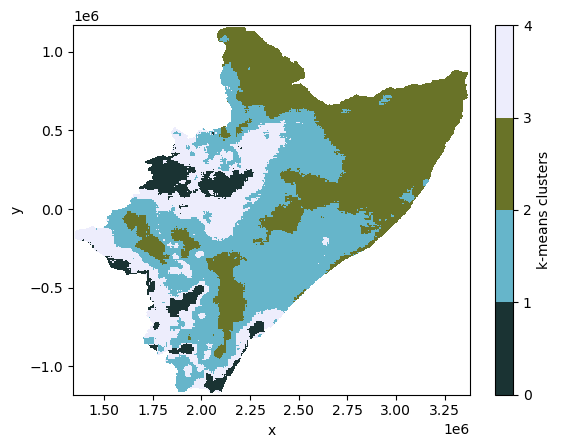

In [23]:
skams_x.plot(cmap=cmc.bukavu, levels=len(kmeans) + 1, vmin=0, vmax=len(kmeans))
# skams_x.plot(cmap=cmc.hawaii_r, levels=len(kmeans) + 1, vmin=0, vmax=len(kmeans))

## <u>QUANTITATIVE COMPARISONS</u> ##

We have visually examined STORM's output... and for better or worse, it does something... even though its stochastic framework hasn't been parameterized yet.\
But is it possible to somehow quantify the/that/those error(s)?

<span style="color:RoyalBlue">We'll need several blocks from notebook [for_](./for_.ipynb) (as we need to read and plot the realization again); and from notebook [tre_](./tre_.ipynb) (as we'd like to have the HAD's SHP).</span>

In [24]:
RAIN_MAP = "../realisation_MAM_crs-OK.nc"  # with interpretable CRS
SUBGROUP = ""
CLUSTERS = 1  # number of regions to split the whole.region into

# OGC-WKT for HAD [taken from https://epsg.io/42106]
WKT_OGC = (
    'PROJCS["WGS84_/_Lambert_Azim_Mozambique",'
    'GEOGCS["unknown",'
    'DATUM["unknown",'
    'SPHEROID["Normal Sphere (r=6370997)",6370997,0]],'
    'PRIMEM["Greenwich",0,'
    'AUTHORITY["EPSG","8901"]],'
    'UNIT["degree",0.0174532925199433,'
    'AUTHORITY["EPSG","9122"]]],'
    'PROJECTION["Lambert_Azimuthal_Equal_Area"],'
    'PARAMETER["latitude_of_center",5],'
    'PARAMETER["longitude_of_center",20],'
    'PARAMETER["false_easting",0],'
    'PARAMETER["false_northing",0],'
    'UNIT["metre",1,'
    'AUTHORITY["EPSG","9001"]],'
    'AXIS["Easting",EAST],'
    'AXIS["Northing",NORTH],'
    'AUTHORITY["EPSG","42106"]]'
)


# this fast-tracks the generation (for this notebook) of coordinates
yyss = np.linspace(1167500.0, -1177500.0, 470, endpoint=True)
xxss = np.linspace(1342500.0, 3377500.0, 408, endpoint=True)


# read the shape
# catchment shape-file in WGS84
SHP_FILE = "../model_input/HAD_basin.shp"
wtrwgs = gpd.read_file(SHP_FILE)

# re-project it
wtrshd = wtrwgs.to_crs(crs=WKT_OGC)  # //epsg.io/42106.wkt


# create an empty numpy
void = np.empty((len(yyss), len(xxss)))
void.fill(np.nan)

# create an empty xarray
void = xr.DataArray(
    data=void,
    dims=["y", "x"],
    # name="void",
    coords=dict(
        y=(["y"], yyss),
        x=(["x"], xxss),
    ),
    attrs=dict(
        _FillValue=np.nan,
        units="mm",
    ),
)

# append the CRS
void.rio.write_crs(rio.crs.CRS(WKT_OGC), grid_mapping_name="spatial_ref", inplace=True)


# read the netcdf file (via rioxarray)
xile = rio.open_rasterio(RAIN_MAP, group=SUBGROUP)

# REMOVING the annoying BAND dimension (assuming we only have ONE band!)
if "band" in list(xile.dims):
    for x in list(xile.data_vars):
        # https://stackoverflow.com/a/41836191/5885810
        xile[x] = xile[x].sel(band=1, drop=True)
    xile = xile.drop_dims(drop_dims="band")

# look up for the CRS?
xvar = xile.rio.grid_mapping
# actual crs
xcrs = xile.rio.crs
# # trasform4fun
# xtra = xile.rio.transform()
xile.close()


# xcrs.is_geographic
# renaming coordinates for 'easy' reprojection?
# https://www.geeksforgeeks.org/python-get-dictionary-keys-as-a-list/
c_xoid = list(void.coords.dims)
# ['y', 'x']
# ['lat', 'lon']
c_xile = list(xile.coords.dims)
# ['lat', 'lon']
# ['band', 'x', 'y']

# https://stackoverflow.com/a/176921/5885810
c_ids = list(map(lambda i: c_xile.index(i), c_xoid))

# assuming LAT goes first
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
# https://stackoverflow.com/a/56163051/5885810  -> rename coordinates
# https://stackoverflow.com/a/51988240/5885810 -> slicing lists
xile = xile.set_index(
    indexes=dict(zip(list(map(c_xile.__getitem__, c_ids)), c_xoid)),
)


# reprojection happens here
rain = xile.rio.reproject_match(void, resampling=Resampling.nearest)

rain

<xarray.Dataset>
Dimensions:   (x: 408, y: 470)
Coordinates:
  * x         (x) float64 1.342e+06 1.348e+06 1.352e+06 ... 3.372e+06 3.378e+06
  * y         (y) float64 1.168e+06 1.162e+06 ... -1.172e+06 -1.178e+06
    xomethin  int64 0
Data variables:
    rain      (y, x) float32 8.853 12.19 12.01 14.22 ... 527.5 527.5 526.5 526.5
    mask      (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0

Check that we have what we need.

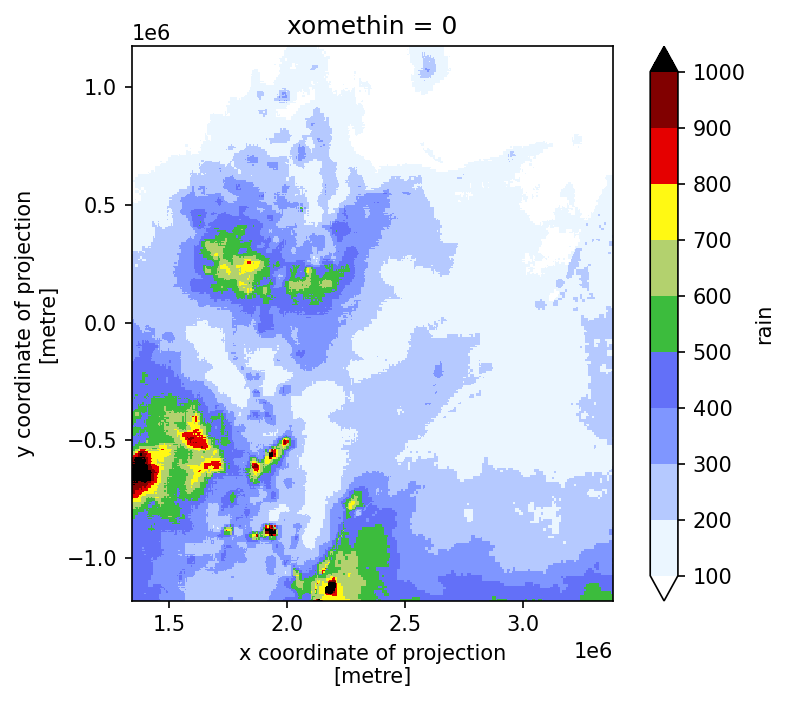

In [25]:
fig, ax = plt.subplots(dpi=150)
ax.set_aspect("equal")

# realization in local CRS
rain["rain"].plot(
    cmap="precip2_17lev",
    levels=10,
    vmin=100,
    vmax=1000,
    add_colorbar=True,
    # robust=True,
)

plt.show()

Trim rainfall outside the HAD.

In [26]:
# update rain
rain = rain["rain"].where(~skams.isnull())

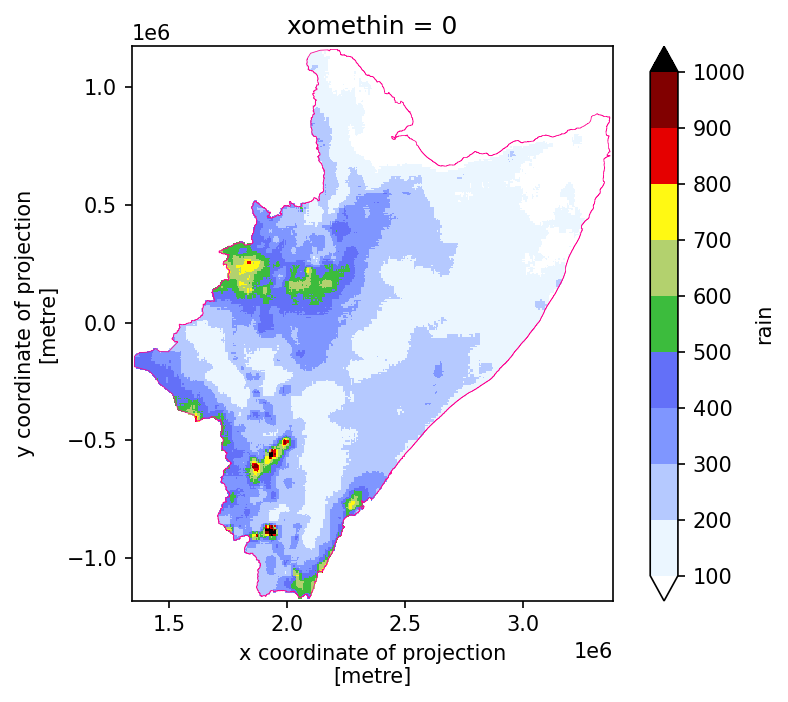

In [27]:
# and plot it again
fig, ax = plt.subplots(dpi=150)
ax.set_aspect("equal")

rain.plot(
    cmap="precip2_17lev",
    levels=10,
    vmin=100,
    vmax=1000,
    add_colorbar=True,
    # robust=True,
)

wtrshd.boundary.plot(ax=ax, color="xkcd:electric pink", lw=0.37, ls="solid")
plt.show()

### RELATIVE BIAS  $\to$  CLUSTERS $\equiv$ 4 ###

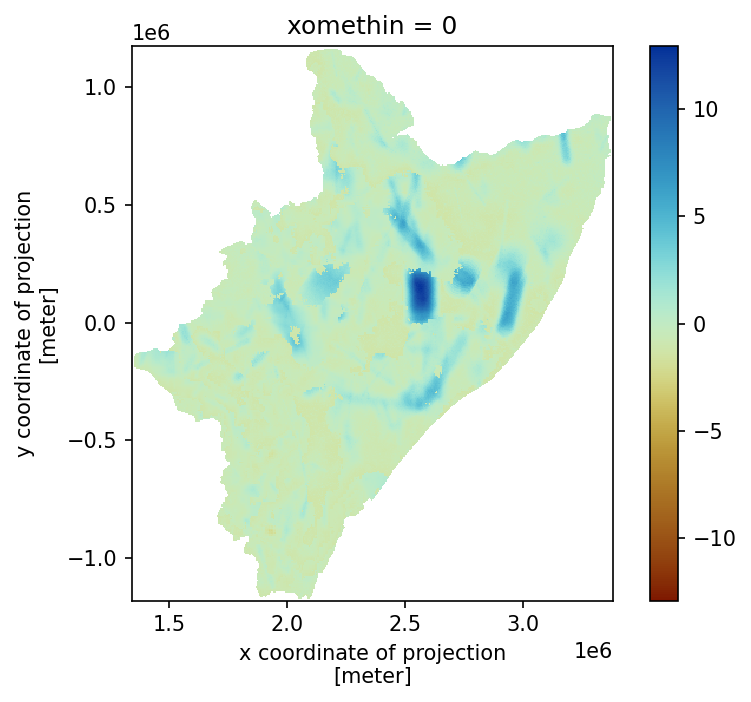

In [28]:
cfor = season_x.copy()
cfor = cfor.where(~skams_x.isnull())

# mask into averages
afor = [skams_x.where(skams_x != i, item) for i, item in enumerate(ks_x)]
afor = xr.concat(afor, dim="mask").sum(dim="mask")  # , skipna=True)
afor = afor.where(~skams_x.isnull())

# relative field
rfor = (cfor - rain) / afor

# plotting happens here
fig, ax = plt.subplots(dpi=150)
ax.set_aspect("equal")

rfor.plot(cmap=cmc.roma)
plt.show()

### RELATIVE BIAS  $\to$  CLUSTERS $\equiv$ 1 ###

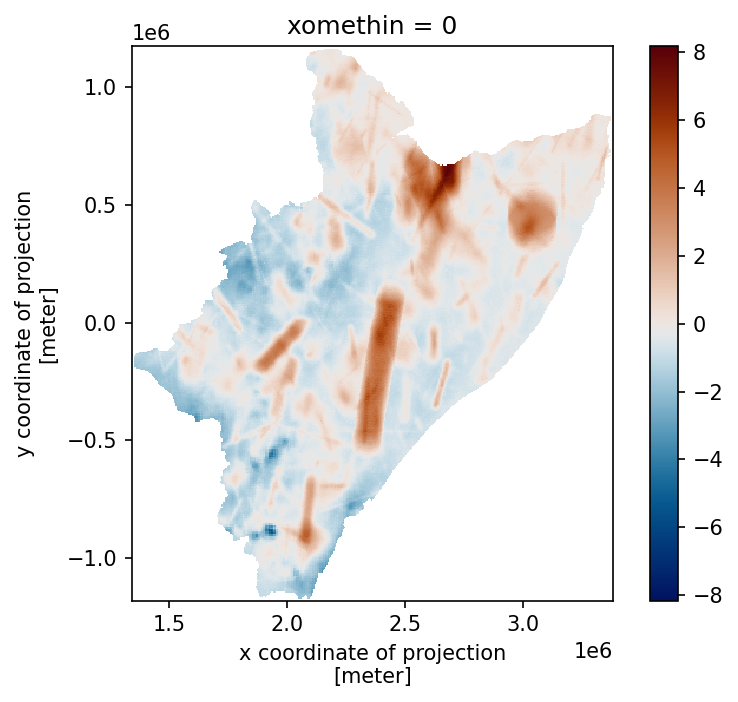

In [29]:
cone = season.copy()
cone = cone.where(~skams.isnull())

# mask into averages
aone = [skams.where(skams != i, item) for i, item in enumerate(ks)]
aone = xr.concat(aone, dim="mask").sum(dim="mask")  # , skipna=True)
aone = aone.where(~skams.isnull())

# relative field
rone = (cone - rain) / aone

# plotting happens here
fig, ax = plt.subplots(dpi=150)
ax.set_aspect("equal")

rone.plot(cmap=cmc.vik)
plt.show()

### SEASONAL [MAM] RAINFALL SIDE-BY-SIDE ###

In [30]:
# rain
one_rain = xr.concat([rain, cone, cfor], dim="case")
one_rain = one_rain.assign_coords(
    {"case": ["mean_MAM [realization]", "1 K-means", "4 K-means"]}
)

<Figure size 960x720 with 0 Axes>

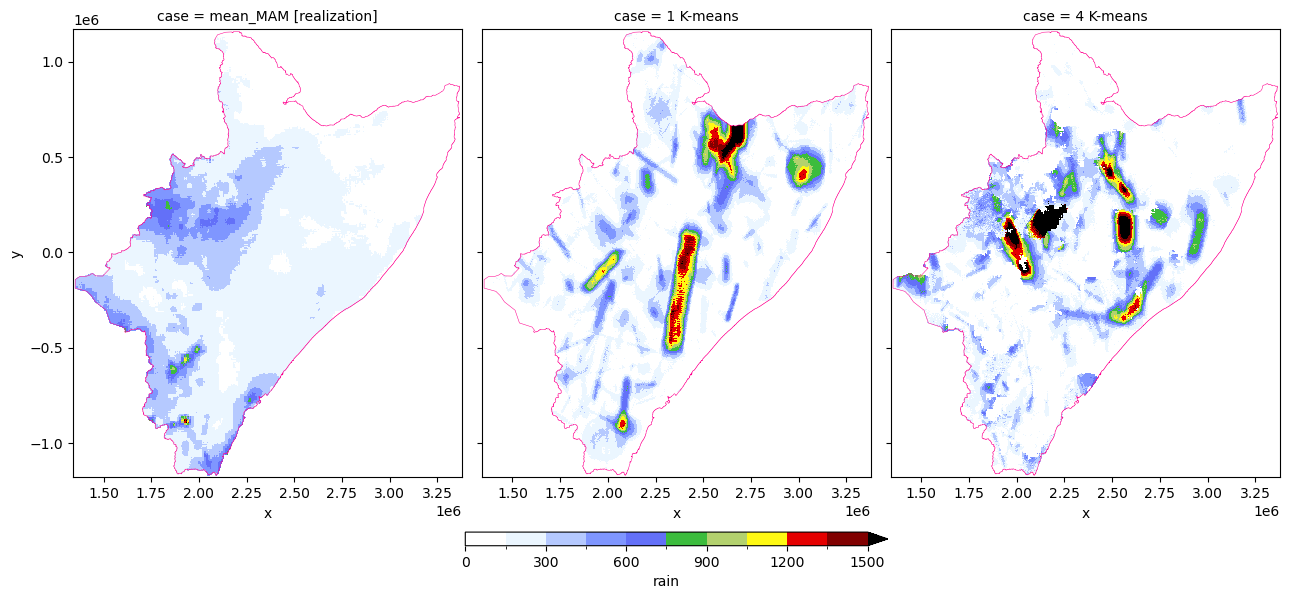

In [134]:
# plot
# https://stackoverflow.com/a/64010463/5885810
# https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.colorbar

fig = plt.figure(dpi=150)

allx = one_rain.plot(
    figsize=(13, 7),
    x="x",
    y="y",
    col="case",
    col_wrap=3,
    aspect=1,
    cmap="precip2_17lev",
    levels=11,
    vmin=0,
    vmax=1500,
    cbar_kwargs={"shrink": 0.35, "pad": +0.09, "aspect": 31, "location": "bottom"},
)

[
    wtrshd.boundary.plot(ax=ax, color="xkcd:electric pink", lw=0.37, ls="solid")
    for ax in allx.axs.flatten()
]

plt.show()

# # use these for exporting and cleaning [don't forget to comment out "plt.show()"!!]
# plt.savefig(
#     "six_.pdf", bbox_inches="tight", pad_inches=0.02, facecolor=fig.get_facecolor()
# )
# plt.close()
# plt.clf()

### [MAM] RELATIVE BIAS SIDE-BY-SIDE ###

In [31]:
# biases
one_diff = xr.concat([rone, rfor], dim="case")
one_diff = one_diff.assign_coords(
    {"case": ["1 K-means [rel.BIAS]", "4 K-means [rel.BIAS]"]}
)

<Figure size 960x720 with 0 Axes>

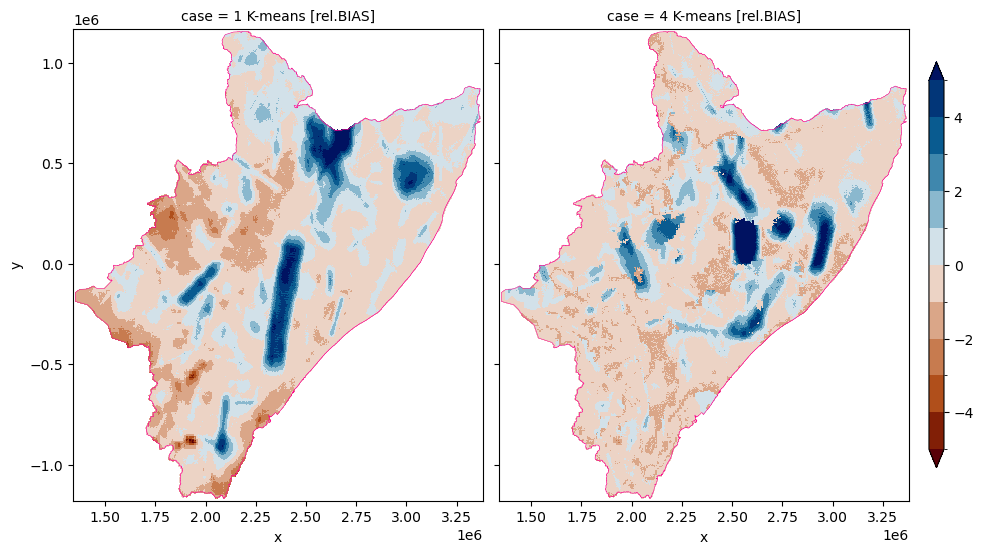

In [32]:
# plot
fig = plt.figure(dpi=150)

alld = one_diff.plot(
    figsize=(11, 6),
    x="x",
    y="y",
    col="case",
    col_wrap=2,
    aspect=1,
    # robust=True,
    cmap=cmc.vik_r,
    levels=11,
    vmin=-5,
    vmax=5,
    cbar_kwargs={"shrink": 4 / 5, "pad": +0.02, "aspect": 27, "location": "right"},
)

[
    wtrshd.boundary.plot(ax=ax, color="xkcd:electric pink", lw=0.37, ls="solid")
    for ax in alld.axs.flatten()
]

plt.show()

---

## <u>30 RUNS</u> ##

![rains](./six_rain.jpg)

![diffs](./six_diff.jpg)

<span style="color:MediumSeaGreen">You're encouraged to: 1) run 30 simulations on STORM; and 2) re-do this notebook for the [OND](../realisation_OND_crs-OK.nc) realization\
You'd need the code below (which was used to produce the plots above) to aggregate all the seasonal storms for the simulated years given in the (NetCDF) files</span>

In [ ]:
# file path for simulations based on 4 CLUSTERS
file4 = "./model_output/RUN_230831T1626_S1_nada_zero.nc"
# file path for simulations based on 1 CLUSTER
file1 = "./model_output/RUN_230830T1734_S1_nada_zero.nc"

# variable name where the rainfall is stored (in the nc.file)
var = "year_2023"


def COLLECT(sfile, grp, var):
    # FUNCTION to collect and aggregate all seasonal storms in a given RUN
    ds = xr.open_mfdataset(
        sfile,
        group=grp,
        combine="nested",
        # concat_dim="time",
        # data_vars=[var],
        decode_times=True,
        use_cftime=True,
        decode_cf=True,
        mask_and_scale=True,
    )
    ds = ds.assign_coords(
        {"y": ds.projection_y_coordinate.load(), "x": ds.projection_x_coordinate.load()}
    )

    # 0.002 is the scaling.factor; -0.00199999999998to1128 is the agg.factor
    # ...usually you don't need to do this; but something went wrong (apparently)
    storm = (
        ((ds[var] * 0.002) + -0.001999999999981128)
        .round(3)
        .astype("f8")
        .sum(dim="time_001")
        .load()
    )
    # use the line below instead, when outputs are produced correctly
    # storm = ds[var].sum(dim="time_001").load()

    skams = ds["k_means"].load()
    ds.close()
    return storm, skams


def COMPUTE(sfile):
    # FUNCTION to call all the RUNS in a file
    # "29" means 30-RUNS (careful with your own simulations)
    xs = list(
        map(
            lambda x: COLLECT(sfile, x, var),
            list(map(lambda x: f"run_{'{:02d}'.format(x)}", np.arange(29) + 1)),
        )
    )
    storm = xr.concat(list(zip(*xs))[0], dim="run").mean(dim="run")
    skams = xr.concat(list(zip(*xs))[-1], dim="run").mean(dim="run")
    return storm, skams


def RELATIVE(season, skams):  # season=s4; skams=k4
    # FUNCTION to compute spatial BIASES
    # mask-dealing
    kmeans = np.unique(skams)
    kmeans = kmeans[~np.isnan(kmeans)].astype("i1")
    # print( [xr.where(skams == x, skams, np.nan).count().data for x in kmeans] )
    ks = list(map(lambda x: xr.where(skams == x, season, np.nan).mean().data, kmeans))
    cx = (season.copy()).where(~skams.isnull())
    # mask into averages
    aa = [skams.where(skams != i, item) for i, item in enumerate(ks)]
    aa = xr.concat(aa, dim="mask").sum(dim="mask").where(~skams.isnull())
    # relative field
    rr = (cx - rain) / aa
    # rr.plot(cmap=cmc.roma)
    return rr

In [ ]:
# put into action all the above functions

# results for 4 CLUSTERS
s4, k4 = COMPUTE(file4)
k4 = COLLECT(file4, "run_30", var)[-1]

# results for 1 CLUSTER
s1, k1 = COMPUTE(file1)
k1 = COLLECT(file1, "run_30", var)[-1]

In [ ]:
# the plotting happens here

# concatenate realization, 4-clusters, and 1-clusters (into ONE Xarray)
rain = rain_fs["rain"].where(~k1.isnull())
one_rain = xr.concat([rain, s1, s4], dim="case")
one_rain = one_rain.assign_coords(
    {"case": ["mean_MAM [realization]", "1K [30runs]", "4K [30runs]"]}
)

# plot the rainfall
fig, ax = plt.subplots(dpi=300)
one_rain.plot(
    figsize=(17, 5),
    x="x",
    y="y",
    col="case",
    col_wrap=3,
    cmap="precip2_17lev",
    levels=11,
    vmin=0,
    vmax=1500,
    cbar_kwargs={"shrink": 4 / 5, "pad": +0.01},
)
plt.savefig(
    f"realisation_plot10--rain.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
    facecolor=fig.get_facecolor(),
)
plt.close()
plt.clf()

# concatenate the relative-bias datasets
one_diff = xr.concat([RELATIVE(s1, k1), RELATIVE(s4, k4)], dim="case")
one_diff = one_diff.assign_coords(
    {"case": ["1K [30runs_rel.BIAS]", "4K [30runs_rel.BIAS]"]}
)

# plot the biases
fig, ax = plt.subplots(dpi=300)
one_diff.plot(
    figsize=(12, 5),
    x="x",
    y="y",
    col="case",
    col_wrap=2,
    # robust=True,
    cmap=cmc.vik_r,
    levels=10,
    vmin=-2,
    vmax=2.5,
    cbar_kwargs={"shrink": 4 / 5, "pad": +0.01},
)
plt.savefig(
    f"realisation_plot10--diff.pdf",
    bbox_inches="tight",
    pad_inches=0.02,
    facecolor=fig.get_facecolor(),
)
plt.close()
plt.clf()